In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
np.random.seed(0)

### Scrap

Fortunately, when we focus on these even-split cases, this type of behavior is easy to generate. Just use:




That is:

$$
\lim_{C\rightarrow \infty}M(\mathcal{S}_C) = 1
$$

Let's try something else: For each category, make a new set where we label things as either that category or not that category. That is, let's make these new sets:

Now, let's do our two element product over each of these:

$$
\begin{align}
M_2\textrm{ Impurity of A's set}=& \frac{4}{12}\big(1-\frac{4}{12}\big)=0.22\\
M_2\textrm{ Impurity of B's set}=& \frac{3}{12}\big(1-\frac{3}{12}\big)=0.19\\
M_2\textrm{ Impurity of C's set}=& \frac{5}{12}\big(1-\frac{5}{12}\big)=0.24\\
\end{align}
$$

$$
\textrm{Gini Impurity} = 0.65
$$

Now how should we combine them? If we take the average, then the max impurity number will still decrease (but less so then earlier). Ok, so let's add them up.

### Final Answer

In answering this question, I'd like to talk about how we might develop this metric ourselves. That process is basically to say 'I want my metric to do act this way in these circumstances' and how to force those behaviors. In the end, you'll see what the Gini impurity measure was going for and I think that's a good way to see the upsides and downsides of such a metric.

First things first - let's be clear about what we are talking about.

Let's say we have data like this:  

![title](S2.png)

Let's call this $\mathcal{S}_2$. We'd like something that is low when $\mathcal{S}_2$ is 'pure' and high when it is.. you guessed it.. impure. Let's calculate something obviously useful:

$$
\begin{align}
p_A & = \frac{\textrm{Number of } A\textrm{'s}}{\textrm{Number of } A\textrm{'s and } B\textrm{'s}} \\
p_B & = \frac{\textrm{Number of } B\textrm{'s}}{\textrm{Number of } A\textrm{'s and } B\textrm{'s}} \\
\end{align}
$$

Any ideas? What about just $p_A$? That's low when the set is full of $A$ (good!), but high when it's full of $B$ (fuck!). We need something symmetric. How about:

$$
M_2(\mathcal{S}_2)=p_A\cdot p_B = p_A\cdot (1-p_A) 
$$

Does this metric (call it $M_2$) do what we want? To get a feel, we can plot this guy as a function of $p_A$: 

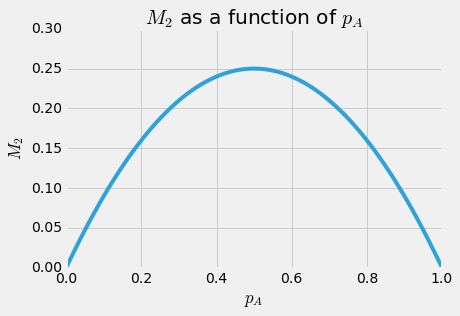

In [2]:
def M2(x):
    return x*(1-x)

pa = np.linspace(0,1,100)
m2 = pd.Series(map(M2,pa),index=pa)

fig, ax = plt.subplots()
m2.plot(ax=ax)
ax.set_ylim(0,.3)
ax.set_xlabel('$p_A$')
ax.set_ylabel('$M_2$')
ax.set_title('$M_2$ as a function of $p_A$')


Nice! It's high right when we have an even mixing and low otherwise - just what we want.

But what if we have something like this?

![title](S3.png)

Let's call this $\mathcal{S}_3$.

This is a little harder. We could do:

$$
p_A\cdot p_B \cdot p_C 
$$

There's a problem though. If we have 'max impurity' split of a $[\frac{1}{3},\frac{1}{3},\frac{1}{3}]$, this tops out at $\frac{1}{27}$. When we only had $A$'s and $B$'s, things capped out at $\frac{1}{4}$. How have we gone *down* in impurity by adding a new category? It should go up! In other words, if I have $C$ categories, then our metric should increase in the cases we see the max-impurity split of $[\frac{1}{C},\frac{1}{C},\cdots,\frac{1}{C}]$. But it shouldn't go up indefinitely. Presumably the difference in impurity due to adding the trillion category should be very small, so it should level out. 

So let's look a function that'll take $[\frac{1}{C},\frac{1}{C},\cdots,\frac{1}{C}]$ and return a larger but plateauing number as $C$ increases. Fortunately, this type of behavior comes up a lot. Just use:

$$
f(C) = \sum_i^C \frac{1}{C}\big(1-\frac{1}{C}\big)
$$

Which looks like:

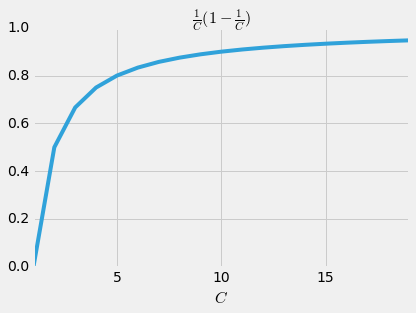

In [3]:
def N_sum(n):
    out = 0
    for i in range(n):
        out += (1/n)*(1-(1/n))
    return out

n = [i for i in range(1,20)]
y = [N_sum(ni) for ni in n]
fig, ax = plt.subplots()
pd.Series(y,index=n).plot(ax=ax)
# ax.set_ylabel('$f(C)$',fontsize=16)
ax.set_xlabel('$C$',fontsize=16)
# ax.set_title('$\\sum_i^C \\frac{1}{C}(1-\\frac{1}{C})$',fontsize=16)
# ax.set_title('$\\sum_i^C$',fontsize=16)
ax.set_title('$\\frac{1}{C}(1-\\frac{1}{C})$',fontsize=16)
# ax.set_title('$\\frac{1}{C}(1-\frac{1}{C})$',fontsize=16)

pass

Ok, so $f(C)$ should be giving us some ideas. How can we smash this and our earlier metric together? Well the only thing I can think of is:

$$
M(\mathcal{S}_2) = p_A\cdot (1-p_A) + p_B\cdot (1-p_B) + p_C\cdot (1-p_C)
$$

And that's your gini impurity measure! We are effectively making a new set for each category, applying our simple, symmetric $M_2$ metric and summing the results:

![title](GiniCalc.png)

And there we have it. We started with something simple/workable in the case of two categories, then we sought some specific behavior as we add categories. We found a function that accomplished that and were able to combine them nicely.

### Ok, but what is this Gini Impurity metric used for?

Ah yes - it's not much use knowing about this metric without knowing it's broader purpose. That is, it's use in decision trees. 

So imagine we have a set with 3 categories, but each element is associated with a real number. So something like this:

In [4]:
cats = ['A','B','C']
cat_map = {'A':'blue','B':'green','C':'red'}
N = 1000
cat_df = pd.DataFrame({'category':np.random.choice(cats,N)})
cat_df['some number'] = np.nan

def GenMixture(left_mean, left_scale, right_mean, right_scale, size, mix = 0.5):
    out = np.random.normal(right_mean,right_scale,size)
    logi = np.random.uniform(size=size) < mix
    out[logi] = np.random.normal(left_mean,left_scale,np.sum(logi))
    return out

logi = cat_df['category']=='A'
cat_df.loc[logi,'some number'] = np.random.normal(3,1,np.sum(logi))
logi = cat_df['category']=='B'
cat_df.loc[logi,'some number'] = GenMixture(2,.9,9,1,np.sum(logi),.5)
logi = cat_df['category']=='C'
cat_df.loc[logi,'some number'] = GenMixture(4,2,5,2,np.sum(logi),.5)

cat_df.head()

,category,some number
0,A,1.820842
1,B,1.455207
2,A,4.301428
3,B,9.755740
4,B,2.027295


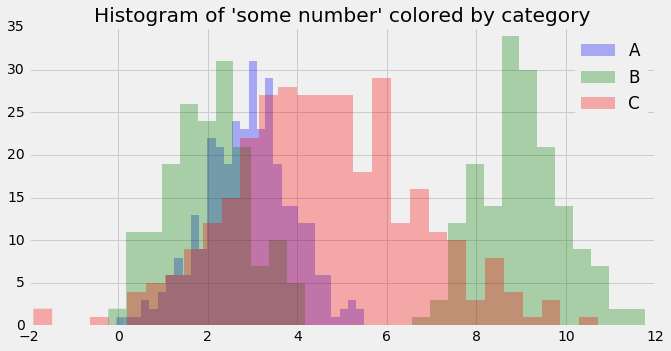

In [5]:
figsize = (10,5)
fig, ax = plt.subplots(figsize=figsize)
n_bins = 30

def make_hist(ax):
    for ct in cats:
        logi = cat_df['category']==ct
        ax.hist(cat_df.loc[logi,'some number'],n_bins,color=cat_map[ct],alpha=.3,linewidth=0,label=ct)
    ax.legend()
    return ax

ax = make_hist(ax)
ax.set_title("Histogram of 'some number' colored by category")
pass

A decision tree is concerned with picking a split point on the 'some number' axis that'll create low impurity on either side of it. So if I were to put a line at the 5 point, I'd see this:

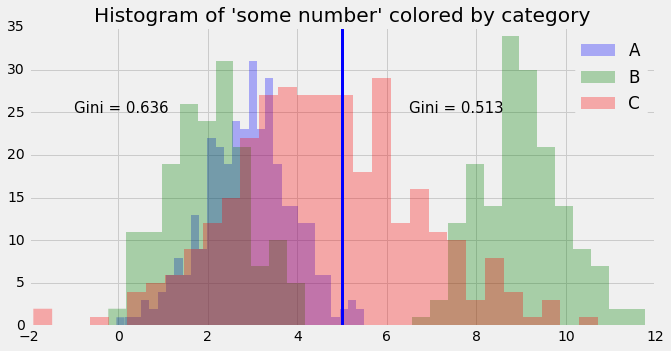

In [6]:
def Gini(cats):
    cat_vals = set(cats)
    gini = 0
    for ct in cat_vals:
        logi = cats == ct
        gini += np.mean(logi)*(1-np.mean(logi))
    return gini

def GiniByLine(x):
    logi = cat_df['some number'] < x
    left = Gini(cat_df.category.values[logi])
    right = Gini(cat_df.category.values[~logi])
    return left, right

def WeightsByLine(x):
    return np.sum(cat_df['some number'] < x),np.sum(~(cat_df['some number'] < x)) 

split = 5
ax.axvline(x=split,linewidth=3)
gini_left, gini_right = GiniByLine(split)
ax.text(-1,25,'Gini = '+str(gini_left)[:5],fontsize=15)
ax.text(6.5,25,'Gini = '+str(gini_right)[:5],fontsize=15)
fig

So to evaluate a split point, we can take the weighted average of the Gini impurity on either side, yielding one number. Now let's do this for all possible split points and pick the one that yields the lowest average impurity on either side.

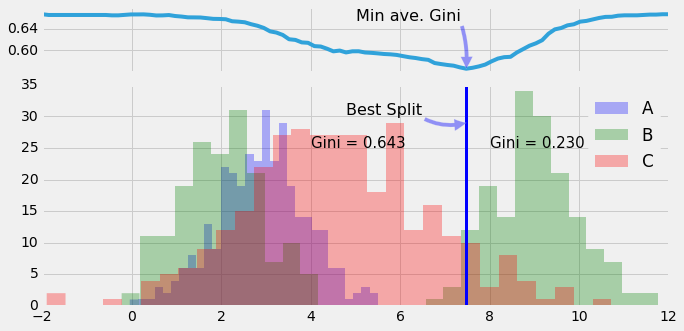

In [20]:
fig2 = plt.figure(3,figsize=figsize)

ax2 = plt.subplot2grid((4, 3), (0, 0), colspan=3)
ax3 = plt.subplot2grid((4, 3), (1, 0), colspan=3, rowspan=3, sharex=ax2)
ax3 = make_hist(ax3)

all_splits = np.linspace(*ax3.get_xlim(),100)
def WeightedGini(x):
    left, right = GiniByLine(x)
    left_w, right_w = WeightsByLine(x)
    
    return (left*left_w + right*right_w)/(left_w+right_w)
    
ginis = pd.Series(map(lambda x: np.mean(WeightedGini(x)),all_splits),index=all_splits)
ginis.plot(kind='line',ax=ax2)
best_split = ginis.argmin()
ax3.axvline(best_split,linewidth=3)
gini_left, gini_right = GiniByLine(best_split)
ax3.text(4,25,'Gini = '+str(gini_left)[:5],fontsize=15)
ax3.text(8,25,'Gini = '+str(gini_right)[:5],fontsize=15)
ax2.annotate('Min ave. Gini',
             xy=(best_split, min(ginis)), xycoords='data',
             xytext=(-110, 48), textcoords='offset points', fontsize=16,
             arrowprops=dict(connectionstyle="arc3,rad=-.1",alpha=.4))
ax2.set_yticks([.6,.64])
ax3.annotate('Best Split',
             xy=(best_split, 29), xycoords='data',
             xytext=(-120, 8), textcoords='offset points', fontsize=16,
             arrowprops=dict(connectionstyle="arc3,rad=.2",alpha=.4))